# 4️⃣ Préparation des données pour la modélisation

Encodage des textes avec BERT et extraction des features d'images avec CNN.

## 📦 Installation et Imports

In [1]:
# Installation des packages nécessaires
!pip install torch torchvision transformers pandas numpy matplotlib seaborn
!pip install scikit-learn requests pillow tqdm
!pip install datasets accelerate tensorboard gradio

import pandas as pd
import numpy as np
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.models import resnet18, resnet50
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Transformers pour BERT
from transformers import AutoTokenizer, AutoModel, get_linear_schedule_with_warmup

# Sklearn pour les métriques
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, roc_curve

# Autres imports
from PIL import Image
import json
import pickle
from datetime import datetime
import gradio as gr
import time

# Configuration
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🔥 Device utilisé: {device}")
print(f"🔥 CUDA disponible: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"🔥 GPU: {torch.cuda.get_device_name(0)}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 46.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 27.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 33.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [9]:
# Monte ton Google Drive dans Colab
from google.colab import drive
drive.mount('/content/drive')
# Remplace les chemins par les bons si besoin
!cp "/content/drive/MyDrive/Colab Notebooks/image_final_ancien.zip" /content/
!cp "/content/drive/MyDrive/Colab Notebooks/df_multimodal_equilibre.csv" /content/
# Extrait le zip
!unzip -q /content/image_final_ancien.zip -d /content/
# Vérification
print("CSV présent :", os.path.exists("/content/df_multimodal_equilibre.csv"))
print("Dossier images présent :", os.path.exists("/content/image_final_ancien"))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
CSV présent : True
Dossier images présent : True


# 📊 1. PRÉPARATION DES DONNÉES POUR LA MODÉLISATION

In [10]:
print("📊 ÉTAPE 1: PRÉPARATION DES DONNÉES POUR LA MODÉLISATION")
print("=" * 80)

# Charger le dataset équilibré
df = pd.read_csv('df_multimodal_equilibre.csv')
print(f"✅ Dataset chargé: {len(df)} articles")
print(f"📊 Répartition des labels:\n{df['label'].value_counts()}")

# Vérifier la structure des données
print(f"\n📋 Colonnes disponibles: {list(df.columns)}")
print(f"🖼️ Articles avec images: {df['has_image'].sum()}")
print(f"📄 Articles avec texte: {df['has_text'].sum()}")
print(f"🔗 Articles multimodaux: {len(df[(df['has_text'] == 1) & (df['has_image'] == 1)])}")

# Affichage des statistiques détaillées par modalité
modality_stats = {
    'title_only': len(df[(df['has_text'] == 0) & (df['has_image'] == 0)]),
    'title_text': len(df[(df['has_text'] == 1) & (df['has_image'] == 0)]),
    'title_image': len(df[(df['has_text'] == 0) & (df['has_image'] == 1)]),
    'multimodal': len(df[(df['has_text'] == 1) & (df['has_image'] == 1)])
}

print(f"\n📊 Répartition par modalité:")
for modality, count in modality_stats.items():
    percentage = (count / len(df)) * 100
    print(f"   - {modality}: {count} articles ({percentage:.1f}%)")

📊 ÉTAPE 1: PRÉPARATION DES DONNÉES POUR LA MODÉLISATION
✅ Dataset chargé: 3410 articles
📊 Répartition des labels:
label
1    1711
0    1699
Name: count, dtype: int64

📋 Colonnes disponibles: ['id_article', 'title', 'text', 'image_path', 'has_text', 'has_image', 'label']
🖼️ Articles avec images: 3166
📄 Articles avec texte: 410
🔗 Articles multimodaux: 166

📊 Répartition par modalité:
   - title_only: 0 articles (0.0%)
   - title_text: 244 articles (7.2%)
   - title_image: 3000 articles (88.0%)
   - multimodal: 166 articles (4.9%)


In [11]:
class MultimodalDataset(Dataset):
    """Dataset personnalisé pour gérer les données multimodales"""
    def __init__(self, dataframe, tokenizer, max_length=512, image_transform=None, images_folder='image_final_ancien'):
        self.df = dataframe.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.image_transform = image_transform
        self.images_folder = images_folder

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # Préparation du texte
        title = str(row['title']) if pd.notna(row['title']) else ""
        text = str(row['text']) if pd.notna(row['text']) and row['has_text'] == 1 else ""

        combined_text = f"{title} [SEP] {text}" if text else title

        # Tokenisation
        encoding = self.tokenizer(
            combined_text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )

        # Préparation de l'image
        image_tensor = torch.zeros(3, 224, 224)
        has_valid_image = False

        if row['has_image'] == 1 and pd.notna(row['image_path']):
            try:
                if os.path.exists(row['image_path']):
                    image = Image.open(row['image_path']).convert('RGB')
                    if self.image_transform:
                        image_tensor = self.image_transform(image)
                    has_valid_image = True
            except Exception as e:
                print(f"⚠️ Erreur chargement image {idx}: {e}")

        # Type de modalité
        modality_type = self._get_modality_type(row['has_text'], has_valid_image)

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'image': image_tensor,
            'label': torch.tensor(row['label'], dtype=torch.long),
            'has_text': torch.tensor(row['has_text'], dtype=torch.float),
            'has_image': torch.tensor(int(has_valid_image), dtype=torch.float),
            'modality_type': modality_type
        }

    def _get_modality_type(self, has_text, has_image):
        if has_text and has_image:
            return 3  # Multimodal
        elif has_text:
            return 2  # Titre + Texte
        elif has_image:
            return 1  # Titre + Image
        else:
            return 0  # Titre seul

# Configuration
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
print("✅ Tokenizer BERT initialisé")

# Division des données
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df['label'])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['label'])

print(f"\n📊 Division des données:")
print(f"   - Train: {len(train_df)} articles")
print(f"   - Validation: {len(val_df)} articles")
print(f"   - Test: {len(test_df)} articles")

# Création des datasets et DataLoaders
train_dataset = MultimodalDataset(train_df, tokenizer, image_transform=image_transform)
val_dataset = MultimodalDataset(val_df, tokenizer, image_transform=image_transform)
test_dataset = MultimodalDataset(test_df, tokenizer, image_transform=image_transform)

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print("✅ DataLoaders créés avec succès")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

✅ Tokenizer BERT initialisé

📊 Division des données:
   - Train: 2387 articles
   - Validation: 511 articles
   - Test: 512 articles
✅ DataLoaders créés avec succès


# 🏗️ 2. ARCHITECTURE DU MODÈLE MULTIMODAL

In [12]:
class MultimodalFakeNewsDetector(nn.Module):
    """Modèle multimodal pour la détection de fausses nouvelles"""
    def __init__(self, bert_model_name='bert-base-uncased', num_classes=2, dropout_rate=0.3):
        super(MultimodalFakeNewsDetector, self).__init__()

        # Composant textuel (BERT)
        self.bert = AutoModel.from_pretrained(bert_model_name)
        self.bert_hidden_size = self.bert.config.hidden_size

        # Composant visuel (ResNet)
        self.resnet = resnet18(pretrained=True)
        self.resnet_features = 512
        self.resnet.fc = nn.Identity()

        # Couches de projection
        self.text_projection = nn.Linear(self.bert_hidden_size, 256)
        self.image_projection = nn.Linear(self.resnet_features, 256)

        # Couches de fusion multimodale
        self.fusion_layer = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(dropout_rate)
        )

        # Têtes de classification spécialisées
        self.text_only_head = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, num_classes)
        )

        self.image_only_head = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, num_classes)
        )

        self.multimodal_head = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(64, num_classes)
        )

        # Couche de confiance
        self.confidence_layer = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

        self.text_to_confidence = nn.Linear(256, 128)
        self.image_to_confidence = nn.Linear(256, 128)

    def forward(self, input_ids, attention_mask, image, has_text, has_image, return_confidence=False):
        batch_size = input_ids.size(0)

        # Extraction des caractéristiques
        text_outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        text_features = text_outputs.pooler_output
        text_projected = self.text_projection(text_features)

        image_features = self.resnet(image)
        image_projected = self.image_projection(image_features)

        # Prédiction adaptative
        predictions = []
        confidences = []

        for i in range(batch_size):
            has_text_i = has_text[i].item()
            has_image_i = has_image[i].item()

            if has_text_i and has_image_i:
                # Multimodal
                fused_features = torch.cat([text_projected[i:i+1], image_projected[i:i+1]], dim=1)
                fused_output = self.fusion_layer(fused_features)
                pred = self.multimodal_head(fused_output)
                base_confidence = 0.90

            elif has_text_i:
                # Texte seulement
                pred = self.text_only_head(text_projected[i:i+1])
                fused_output = self.text_to_confidence(text_projected[i:i+1])
                base_confidence = 0.85

            elif has_image_i:
                # Image seulement
                pred = self.image_only_head(image_projected[i:i+1])
                fused_output = self.image_to_confidence(image_projected[i:i+1])
                base_confidence = 0.85

            else:
                # Titre seul
                pred = self.text_only_head(text_projected[i:i+1])
                fused_output = self.text_to_confidence(text_projected[i:i+1])
                base_confidence = 0.75

            predictions.append(pred)

            if return_confidence:
                dynamic_confidence = self.confidence_layer(fused_output).item()
                final_confidence = base_confidence * dynamic_confidence
                confidences.append(final_confidence)

        predictions = torch.cat(predictions, dim=0)

        if return_confidence:
            return predictions, confidences
        return predictions

# Initialisation du modèle
model = MultimodalFakeNewsDetector().to(device)
print("✅ Modèle multimodal initialisé")

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"📊 Paramètres totaux: {total_params:,}")
print(f"📊 Paramètres entraînables: {trainable_params:,}")

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 53.1MB/s]


✅ Modèle multimodal initialisé
📊 Paramètres totaux: 121,299,975
📊 Paramètres entraînables: 121,299,975


# 🚀 3. ENTRAÎNEMENT DU MODÈLE

In [13]:
print("\n🚀 ÉTAPE 3: ENTRAÎNEMENT DU MODÈLE")
print("=" * 80)

# Configuration
config = {
    'epochs': 10,
    'learning_rate': 2e-5,
    'weight_decay': 0.01,
    'warmup_steps': 100,
    'patience': 3,
    'save_dir': 'checkpoints',
    'best_model_path': 'best_multimodal_model.pth'
}

os.makedirs(config['save_dir'], exist_ok=True)

# Optimiseur et scheduler
optimizer = optim.AdamW(model.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])
total_steps = len(train_loader) * config['epochs']
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=config['warmup_steps'],
    num_training_steps=total_steps
)

criterion = nn.CrossEntropyLoss()

# Variables de suivi
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
best_val_accuracy = 0.0
patience_counter = 0

def train_epoch(model, train_loader, optimizer, scheduler, criterion, device):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0

    progress_bar = tqdm(train_loader, desc="Entraînement")

    for batch in progress_bar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        images = batch['image'].to(device)
        labels = batch['label'].to(device)
        has_text = batch['has_text'].to(device)
        has_image = batch['has_image'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask, images, has_text, has_image)
        loss = criterion(outputs, labels)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

        progress_bar.set_postfix({
            'Loss': f'{loss.item():.4f}',
            'Acc': f'{100 * correct_predictions / total_predictions:.2f}%'
        })

    return total_loss / len(train_loader), correct_predictions / total_predictions

def validate_epoch(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validation"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            images = batch['image'].to(device)
            labels = batch['label'].to(device)
            has_text = batch['has_text'].to(device)
            has_image = batch['has_image'].to(device)

            outputs = model(input_ids, attention_mask, images, has_text, has_image)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_predictions += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

    return total_loss / len(val_loader), correct_predictions / total_predictions


🚀 ÉTAPE 3: ENTRAÎNEMENT DU MODÈLE


In [14]:
# Boucle d'entraînement
print(f"🚀 Début de l'entraînement pour {config['epochs']} époques")
start_time = datetime.now()

for epoch in range(config['epochs']):
    print(f"\n📅 Époque {epoch + 1}/{config['epochs']}")

    # Entraînement et validation
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, scheduler, criterion, device)
    val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)

    # Sauvegarde des métriques
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"📊 Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"📊 Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

    # Sauvegarde du meilleur modèle
    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        patience_counter = 0
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_accuracy': val_acc,
            'config': config
        }, config['best_model_path'])
        print(f"💾 Nouveau meilleur modèle sauvegardé: {config['best_model_path']}")
    else:
        patience_counter += 1

    # Early stopping
    if patience_counter >= config['patience']:
        print(f"🛑 Early stopping après {epoch + 1} époques")
        break

end_time = datetime.now()
print(f"\n⏱️ Durée d'entraînement: {end_time - start_time}")
print(f"🏆 Meilleure précision: {best_val_accuracy:.4f}")

🚀 Début de l'entraînement pour 10 époques

📅 Époque 1/10


Validation: 100%|██████████| 32/32 [00:15<00:00,  2.02it/s]


📊 Train Loss: 0.4381 | Train Acc: 0.8165
📊 Val Loss: 0.1451 | Val Acc: 0.9452
💾 Nouveau meilleur modèle sauvegardé: best_multimodal_model.pth

📅 Époque 2/10


Validation: 100%|██████████| 32/32 [00:15<00:00,  2.02it/s]


📊 Train Loss: 0.1562 | Train Acc: 0.9284
📊 Val Loss: 0.1482 | Val Acc: 0.9217

📅 Époque 3/10


Validation: 100%|██████████| 32/32 [00:15<00:00,  2.02it/s]


📊 Train Loss: 0.1124 | Train Acc: 0.9485
📊 Val Loss: 0.1343 | Val Acc: 0.9256

📅 Époque 4/10


Validation: 100%|██████████| 32/32 [00:15<00:00,  2.03it/s]

📊 Train Loss: 0.1047 | Train Acc: 0.9506
📊 Val Loss: 0.1523 | Val Acc: 0.9256
🛑 Early stopping après 4 époques

⏱️ Durée d'entraînement: 0:15:35.068744
🏆 Meilleure précision: 0.9452


# 📊 4. VISUALISATION ET ÉVALUATION

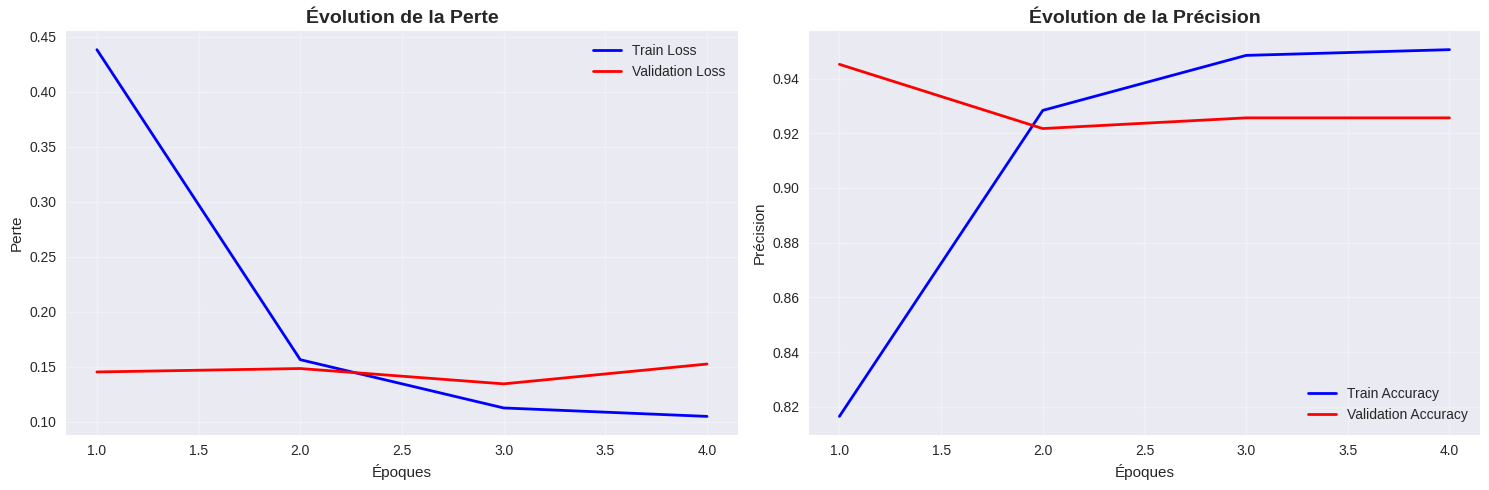

✅ Courbes d'entraînement sauvegardées


In [15]:
# Visualisation des courbes d'entraînement
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

epochs_range = range(1, len(train_losses) + 1)

# Courbes de perte
ax1.plot(epochs_range, train_losses, 'b-', label='Train Loss', linewidth=2)
ax1.plot(epochs_range, val_losses, 'r-', label='Validation Loss', linewidth=2)
ax1.set_title('Évolution de la Perte', fontsize=14, fontweight='bold')
ax1.set_xlabel('Époques')
ax1.set_ylabel('Perte')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Courbes de précision
ax2.plot(epochs_range, train_accuracies, 'b-', label='Train Accuracy', linewidth=2)
ax2.plot(epochs_range, val_accuracies, 'r-', label='Validation Accuracy', linewidth=2)
ax2.set_title('Évolution de la Précision', fontsize=14, fontweight='bold')
ax2.set_xlabel('Époques')
ax2.set_ylabel('Précision')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Courbes d'entraînement sauvegardées")


🔍 ÉVALUATION SUR LE DATASET DE TEST


Test: 100%|██████████| 32/32 [00:16<00:00,  1.98it/s]


📊 RÉSULTATS FINAUX:
   - Précision: 0.9258
   - F1-Score: 0.9257
   - Confiance moyenne: 0.3745

📊 RÉSULTATS PAR MODALITÉ:
   - Titre seul: 0.9758 (444/455)
   - Titre + Texte: 0.5263 (30/57)


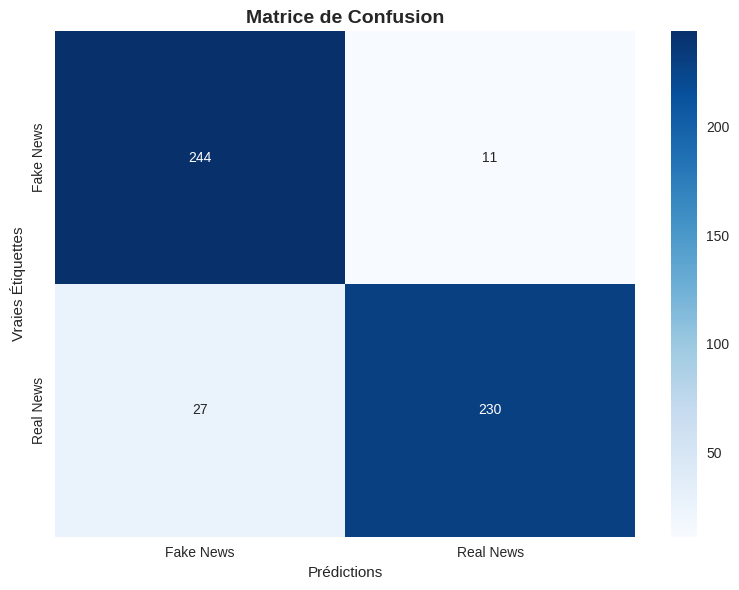


✅ Évaluation terminée et résultats sauvegardés


In [16]:
# Évaluation sur le dataset de test
print("\n🔍 ÉVALUATION SUR LE DATASET DE TEST")
print("=" * 50)

# Charger le meilleur modèle
best_checkpoint = torch.load(config['best_model_path'])
model.load_state_dict(best_checkpoint['model_state_dict'])
model.eval()

# Évaluation détaillée
all_predictions = []
all_labels = []
all_confidences = []
modality_stats = {0: {'correct': 0, 'total': 0}, 1: {'correct': 0, 'total': 0},
                  2: {'correct': 0, 'total': 0}, 3: {'correct': 0, 'total': 0}}

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Test"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        images = batch['image'].to(device)
        labels = batch['label'].to(device)
        has_text = batch['has_text'].to(device)
        has_image = batch['has_image'].to(device)
        modality_types = batch['modality_type']

        outputs, confidences = model(input_ids, attention_mask, images, has_text, has_image, return_confidence=True)
        _, predicted = torch.max(outputs, 1)

        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_confidences.extend(confidences)

        # Statistiques par modalité
        for i in range(len(predicted)):
            modality = modality_types[i].item()
            modality_stats[modality]['total'] += 1
            if predicted[i] == labels[i]:
                modality_stats[modality]['correct'] += 1

# Métriques globales
accuracy = accuracy_score(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions, average='weighted')
avg_confidence = np.mean(all_confidences)

print(f"📊 RÉSULTATS FINAUX:")
print(f"   - Précision: {accuracy:.4f}")
print(f"   - F1-Score: {f1:.4f}")
print(f"   - Confiance moyenne: {avg_confidence:.4f}")

# Métriques par modalité
modality_names = {0: 'Titre seul', 1: 'Titre + Image', 2: 'Titre + Texte', 3: 'Multimodal'}
print(f"\n📊 RÉSULTATS PAR MODALITÉ:")
for modality, stats in modality_stats.items():
    if stats['total'] > 0:
        acc = stats['correct'] / stats['total']
        print(f"   - {modality_names[modality]}: {acc:.4f} ({stats['correct']}/{stats['total']})")

# Matrice de confusion
cm = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Fake News', 'Real News'],
            yticklabels=['Fake News', 'Real News'])
plt.title('Matrice de Confusion', fontsize=14, fontweight='bold')
plt.xlabel('Prédictions')
plt.ylabel('Vraies Étiquettes')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Évaluation terminée et résultats sauvegardés")

# 🎯 5. INTERFACE DE PRÉDICTION EN TEMPS RÉEL

In [17]:
class FakeNewsPredictor:
    """Classe pour les prédictions en temps réel"""

    def __init__(self, model, tokenizer, image_transform, device):
        self.model = model
        self.tokenizer = tokenizer
        self.image_transform = image_transform
        self.device = device
        self.model.eval()

        self.label_mapping = {0: "Fake News", 1: "Real News"}
        self.confidence_levels = {
            0: "Faible (70-80%)",
            1: "Moyenne (80-90%)",
            2: "Moyenne (80-90%)",
            3: "Élevée (90%+)"
        }

    def predict(self, title, text="", image_path=None):
        """Prédiction sur un article"""
        # Préparation du texte
        has_text = 1 if text and len(text.strip()) >= 50 else 0
        combined_text = f"{title} [SEP] {text}" if has_text else title

        # Tokenisation
        encoding = self.tokenizer(
            combined_text,
            truncation=True,
            padding='max_length',
            max_length=512,
            return_tensors='pt'
        )

        # Préparation de l'image
        image_tensor = torch.zeros(1, 3, 224, 224)
        has_image = 0

        if image_path and os.path.exists(image_path):
            try:
                image = Image.open(image_path).convert('RGB')
                image_tensor = self.image_transform(image).unsqueeze(0)
                has_image = 1
            except Exception as e:
                print(f"Erreur chargement image: {e}")

        # Déplacement vers GPU
        input_ids = encoding['input_ids'].to(self.device)
        attention_mask = encoding['attention_mask'].to(self.device)
        image_tensor = image_tensor.to(self.device)
        has_text_tensor = torch.tensor([has_text], dtype=torch.float).to(self.device)
        has_image_tensor = torch.tensor([has_image], dtype=torch.float).to(self.device)

        # Prédiction
        with torch.no_grad():
            outputs, confidences = self.model(
                input_ids, attention_mask, image_tensor,
                has_text_tensor, has_image_tensor,
                return_confidence=True
            )

            probabilities = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)

            prediction = predicted.item()
            confidence = confidences[0]
            prob_fake = probabilities[0][0].item()
            prob_real = probabilities[0][1].item()

        # Détermination du type de modalité
        if has_text and has_image:
            modality_type = 3
        elif has_text:
            modality_type = 2
        elif has_image:
            modality_type = 1
        else:
            modality_type = 0

        return {
            'prediction': self.label_mapping[prediction],
            'confidence': confidence,
            'confidence_level': self.confidence_levels[modality_type],
            'probabilities': {
                'fake': prob_fake,
                'real': prob_real
            },
            'modality_type': modality_type,
            'has_text': bool(has_text),
            'has_image': bool(has_image)
        }

# Initialisation du prédicteur
predictor = FakeNewsPredictor(model, tokenizer, image_transform, device)
print("✅ Prédicteur initialisé")

✅ Prédicteur initialisé


In [18]:
# Test de prédiction
def test_prediction():
    print("\n🎯 TEST DE PRÉDICTION")
    print("=" * 50)

    # Exemple 1: Titre seul
    title1 = "Breaking: Scientists discover cure for all diseases"
    result1 = predictor.predict(title1)

    print(f"📰 Test 1 - Titre seul:")
    print(f"   Titre: {title1}")
    print(f"   Prédiction: {result1['prediction']}")
    print(f"   Confiance: {result1['confidence']:.3f} ({result1['confidence_level']})")
    print(f"   Probabilités: Fake={result1['probabilities']['fake']:.3f}, Real={result1['probabilities']['real']:.3f}")

    # Exemple 2: Titre + Texte
    title2 = "New study reveals important findings about climate change"
    text2 = "Researchers from leading universities have published a comprehensive study in Nature journal showing significant evidence of accelerating climate change effects. The study, which analyzed data from over 50 countries spanning 30 years, provides crucial insights into global warming patterns and their impact on ecosystems worldwide."
    result2 = predictor.predict(title2, text2)

    print(f"\n📰 Test 2 - Titre + Texte:")
    print(f"   Titre: {title2}")
    print(f"   Texte: {text2[:100]}...")
    print(f"   Prédiction: {result2['prediction']}")
    print(f"   Confiance: {result2['confidence']:.3f} ({result2['confidence_level']})")
    print(f"   Probabilités: Fake={result2['probabilities']['fake']:.3f}, Real={result2['probabilities']['real']:.3f}")

    print("\n✅ Tests de prédiction terminés")

test_prediction()


🎯 TEST DE PRÉDICTION
📰 Test 1 - Titre seul:
   Titre: Breaking: Scientists discover cure for all diseases
   Prédiction: Real News
   Confiance: 0.351 (Faible (70-80%))
   Probabilités: Fake=0.066, Real=0.934

📰 Test 2 - Titre + Texte:
   Titre: New study reveals important findings about climate change
   Texte: Researchers from leading universities have published a comprehensive study in Nature journal showing...
   Prédiction: Real News
   Confiance: 0.406 (Moyenne (80-90%))
   Probabilités: Fake=0.174, Real=0.826

✅ Tests de prédiction terminés


# 💾 6. SAUVEGARDE ET EXPORT DU MODÈLE

In [19]:
print("\n💾 SAUVEGARDE ET EXPORT DU MODÈLE")
print("=" * 50)

# Sauvegarde des résultats finaux
final_results = {
    'model_info': {
        'architecture': 'MultimodalFakeNewsDetector',
        'bert_model': 'bert-base-uncased',
        'cnn_model': 'resnet18',
        'total_parameters': total_params,
        'trainable_parameters': trainable_params
    },
    'training_config': config,
    'final_metrics': {
        'test_accuracy': float(accuracy),
        'test_f1_score': float(f1),
        'average_confidence': float(avg_confidence),
        'best_val_accuracy': float(best_val_accuracy)
    },
    'modality_performance': {},
    'training_history': {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies
    }
}

# Ajouter les performances par modalité
for modality, stats in modality_stats.items():
    if stats['total'] > 0:
        final_results['modality_performance'][modality_names[modality]] = {
            'accuracy': float(stats['correct'] / stats['total']),
            'samples': stats['total']
        }

# Sauvegarde JSON
with open('final_results.json', 'w') as f:
    json.dump(final_results, f, indent=2)

# Sauvegarde du tokenizer
tokenizer.save_pretrained('saved_tokenizer')

# Sauvegarde des transformations d'images
with open('image_transform.pkl', 'wb') as f:
    pickle.dump(image_transform, f)

print("✅ Résultats finaux sauvegardés: final_results.json")
print("✅ Tokenizer sauvegardé: saved_tokenizer/")
print("✅ Transformations d'images sauvegardées: image_transform.pkl")
print(f"✅ Meilleur modèle disponible: {config['best_model_path']}")

print(f"\n🎉 PIPELINE DE MODÉLISATION TERMINÉ AVEC SUCCÈS!")
print(f"📊 Précision finale: {accuracy:.4f}")
print(f"📊 F1-Score: {f1:.4f}")
print(f"📊 Confiance moyenne: {avg_confidence:.4f}")


💾 SAUVEGARDE ET EXPORT DU MODÈLE
✅ Résultats finaux sauvegardés: final_results.json
✅ Tokenizer sauvegardé: saved_tokenizer/
✅ Transformations d'images sauvegardées: image_transform.pkl
✅ Meilleur modèle disponible: best_multimodal_model.pth

🎉 PIPELINE DE MODÉLISATION TERMINÉ AVEC SUCCÈS!
📊 Précision finale: 0.9258
📊 F1-Score: 0.9257
📊 Confiance moyenne: 0.3745
